In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
pd.options.display.max_columns = 200
sns.set_theme(style='darkgrid')

In [3]:
df = pd.read_csv('Data/processed.csv')
df.head(5)

,Altmetric_Attention_Score,Title,Journal/Collection_Title,Output_Type,OA_Status,OA_Type,Subjects_(FoR),Affiliations_(GRID),Publication_Date,News_mentions,...,OA_Type_LE,Publisher_Names_LE,University_LE,Category_1_LE,Category_2_LE,Category_3_LE,Category_4_LE,Category_5_LE,Category_6_LE,Category_7_LE
0,1629,COVID-19 and male reproductive function: a pro...,Reproduction,Article,True,bronze,11 Medical and Health Sciences; 1114 Paediatri...,Allameh Tabataba'i University; University of G...,2021-03-01,87,...,0,189,0,11,23,22,0,0,0,0
1,906,The effects of three different exercise modali...,Reproduction,Article,True,bronze,11 Medical and Health Sciences; 1103 Clinical ...,"Academic Center for Education, Culture and Res...",2017-02-01,128,...,0,189,0,11,23,22,0,0,0,0
2,239,"Fear, Loss, Social Isolation, and Incomplete G...",Basic And Clinical Neuroscience,Article,True,gold,11 Medical and Health Sciences; 1117 Public He...,Allameh Tabataba'i University; Charles R. Drew...,2020-07-30,30,...,2,189,0,11,34,0,0,0,0,0
3,175,Foundations of Social Policy and Welfare in Islam,No Title,Chapter,False,closed,16 Studies in Human Society; 1605 Policy and A...,Allameh Tabataba'i University,2020-12-19,21,...,1,171,0,16,21,39,0,0,0,0
4,102,Laughter yoga versus group exercise program in...,International Journal of Geriatric Psychiatry,Article,True,green,11 Medical and Health Sciences; 1103 Clinical ...,Allameh Tabataba'i University; Imam Khomeini H...,2010-09-16,9,...,3,75,0,11,24,32,0,0,0,0


In [11]:
COL_DATE = 'Publication_Date'
COL_AAS = 'Altmetric_Attention_Score'
COL_UNI = 'University'

In [12]:
df[COL_DATE] = pd.to_datetime(df[COL_DATE], errors='coerce')
df = df.dropna(subset=[COL_DATE])

# year
df['year'] = df[COL_DATE].dt.year

# AAS numeric
df[COL_AAS] = pd.to_numeric(df[COL_AAS], errors='coerce')
d = df.dropna(subset=[COL_AAS])

# breath indicator
df['has_attention'] = (df[COL_AAS] > 0).astype(int)

# Optional: remove obviously wrong years (e.g., < 1990 or > current year)
df = df[(df["year"] >= 1990) & (df["year"] <= pd.Timestamp.today().year)]

In [14]:
yearly = (
    df.groupby('year')
    .agg(
        n_pubs = (COL_AAS, 'size'),
        mean_aas = (COL_AAS, 'mean'),
        median_aas = (COL_AAS, 'median'),
        p90_aas = (COL_AAS, lambda s: np.percentile(s, 90)),
        coverage_pct = (COL_AAS, lambda s: (s>0).mean() * 100)
    )
    .reset_index()
)
yearly.sort_values('year').head(), yearly.tail()

(   year  n_pubs  mean_aas  median_aas  p90_aas  coverage_pct
 0  1990       7  3.857143         6.0      6.0     71.428571
 1  1991      11  2.454545         3.0      3.0     72.727273
 2  1992      16  1.500000         0.0      4.5     37.500000
 3  1993       9  1.333333         0.0      3.0     44.444444
 4  1994      29  1.103448         0.0      3.0     34.482759,
     year  n_pubs  mean_aas  median_aas  p90_aas  coverage_pct
 29  2019    6136  4.014505         1.0      5.0     68.758149
 30  2020    6750  4.850370         1.0      6.0     72.103704
 31  2021    8264  3.685140         1.0      5.0     78.412391
 32  2022    7690  4.151105         1.0      5.0     82.522757
 33  2023     703  2.120910         1.0      4.0     85.064011)

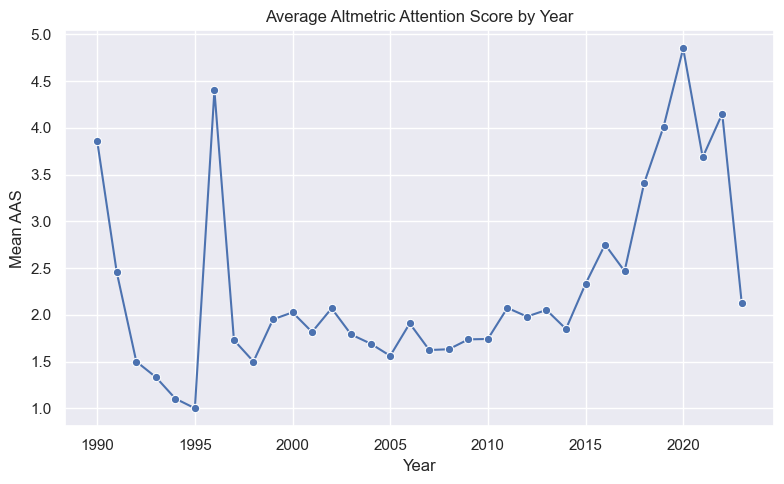

In [15]:
# (A) average aas by year
plt.figure(figsize=(8, 5))
sns.lineplot(data=yearly, x='year', y='mean_aas', marker='o')
plt.title('Average Altmetric Attention Score by Year')
plt.xlabel('Year')
plt.ylabel('Mean AAS')
plt.tight_layout()
plt.show()

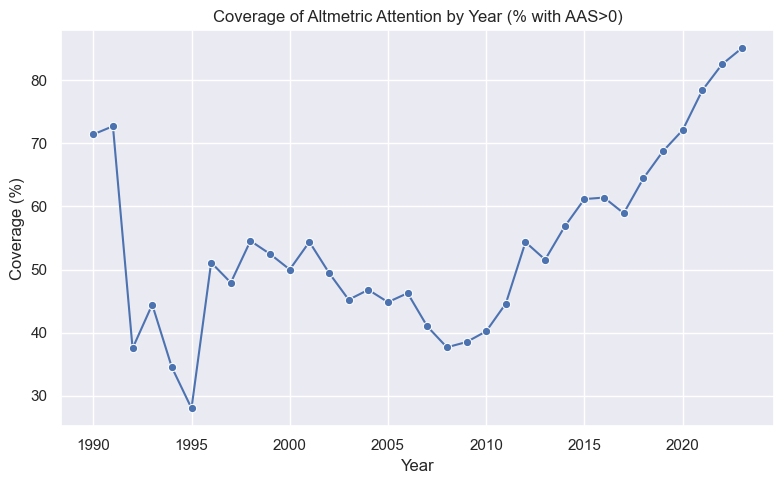

In [26]:
# (B) Coverage (% AAS > 0) by year
plt.figure(figsize=(8, 5))
sns.lineplot(data=yearly, x='year', y='coverage_pct', marker='o')
plt.title('Coverage of Altmetric Attention by Year (% with AAS>0)')
plt.xlabel('Year')
plt.ylabel('Coverage (%)')
plt.tight_layout()
plt.show()

In [18]:
X = sm.add_constant(df['year'])
y_log = np.log1p(df[COL_AAS])

ols_log = sm.OLS(y_log, X).fit(cov_type='HC1') # robust SEs
print(ols_log.summary())

# helpful derived quantities
beta_year = ols_log.params['year']
# the below line:
# ≈ % change in geometric mean per year
or_like_pct = (np.exp(beta_year) - 1) * 100 
print({'beta_year': beta_year, 'approx_%_per_year': or_like_pct})

                                OLS Regression Results                               
Dep. Variable:     Altmetric_Attention_Score   R-squared:                       0.011
Model:                                   OLS   Adj. R-squared:                  0.011
Method:                        Least Squares   F-statistic:                     778.5
Date:                       Fri, 29 Aug 2025   Prob (F-statistic):          1.97e-170
Time:                               12:59:58   Log-Likelihood:                -85109.
No. Observations:                      73087   AIC:                         1.702e+05
Df Residuals:                          73085   BIC:                         1.702e+05
Df Model:                                  1                                         
Covariance Type:                         HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

In [19]:
ols_raw = sm.OLS(df[COL_AAS], X).fit(cov_type="HC1")
print(ols_raw.summary())

                                OLS Regression Results                               
Dep. Variable:     Altmetric_Attention_Score   R-squared:                       0.001
Model:                                   OLS   Adj. R-squared:                  0.001
Method:                        Least Squares   F-statistic:                     74.49
Date:                       Fri, 29 Aug 2025   Prob (F-statistic):           6.20e-18
Time:                               13:00:42   Log-Likelihood:            -3.6078e+05
No. Observations:                      73087   AIC:                         7.216e+05
Df Residuals:                          73085   BIC:                         7.216e+05
Df Model:                                  1                                         
Covariance Type:                         HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

In [21]:
logit = sm.Logit(df['has_attention'], X).fit(disp=False)
print(logit.summary())

beta_year_logit = logit.params['year']
odds_ratio = float(np.exp(beta_year_logit))
print({'beta_year_logit': beta_year_logit, 'odds_ratio_per_year': odds_ratio})

                           Logit Regression Results                           
Dep. Variable:          has_attention   No. Observations:                73087
Model:                          Logit   Df Residuals:                    73085
Method:                           MLE   Df Model:                            1
Date:                Fri, 29 Aug 2025   Pseudo R-squ.:                 0.04497
Time:                        13:06:02   Log-Likelihood:                -45800.
converged:                       True   LL-Null:                       -47957.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -221.0482      3.503    -63.094      0.000    -227.915    -214.182
year           0.1099      0.002     63.248      0.000       0.107       0.113
{'beta_year_logit': np.float64(0.10990973861924602),

In [22]:
# sensitivity analysis
df_recent = df[df['year'] >= 2010].copy()
Xr = sm.add_constant(df_recent['year'])

ols_log_r = sm.OLS(np.log1p(df_recent[COL_AAS]), Xr).fit(cov_type='HC1')
print(ols_log_r.summary)

logit_r = sm.Logit(df_recent['has_attention'], Xr).fit(disp=False)
print(logit_r.summary())

beta_r = ols_log_r.params["year"]
pct_r  = (np.exp(beta_r) - 1) * 100
or_r   = float(np.exp(logit_r.params["year"]))
print({"log_model_%_per_year_2010plus": pct_r, "logit_odds_ratio_per_year_2010plus": or_r})

<bound method RegressionResults.summary of <statsmodels.regression.linear_model.OLSResults object at 0x14b950710>>
                           Logit Regression Results                           
Dep. Variable:          has_attention   No. Observations:                66602
Model:                          Logit   Df Residuals:                    66600
Method:                           MLE   Df Model:                            1
Date:                Fri, 29 Aug 2025   Pseudo R-squ.:                 0.04051
Time:                        13:18:51   Log-Likelihood:                -41122.
converged:                       True   LL-Null:                       -42858.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -280.8335      4.875    -57.609      0.000    -290.388    -271.279
year           0

In [25]:
if COL_UNI in df.columns:
    rows = []
    for uni, d in df.groupby(COL_UNI):
        # Skip tiny series
        if d["year"].nunique() < 3 or len(d) < 50:
            continue
        Xu = sm.add_constant(d["year"])
        ols_u = sm.OLS(np.log1p(d[COL_AAS]), Xu).fit(cov_type="HC1")
        logit_u = sm.Logit(d["has_attention"], Xu).fit(disp=False)
        rows.append({
            "University": uni,
            "n_records": len(d),
            "years_span": f"{int(d['year'].min())}-{int(d['year'].max())}",
            "slope_logAAS": ols_u.params["year"],
            "p_logAAS": ols_u.pvalues["year"],
            "logit_slope": logit_u.params["year"],
            "p_logit": logit_u.pvalues["year"],
            "logit_odds_ratio": float(np.exp(logit_u.params["year"]))
        })
    uni_trends = pd.DataFrame(rows).sort_values("slope_logAAS", ascending=False)
uni_trends

,University,n_records,years_span,slope_logAAS,p_logAAS,logit_slope,p_logit,logit_odds_ratio
4,Iran University of Science and Technology,4343,1992-2023,0.021143,3.692700e-25,0.133628,9.599764e-79,1.142967
8,Sharif University of Technology,6789,1990-2023,0.020769,2.758580e-28,0.104442,2.295039e-88,1.110092
7,Shahid Beheshti University,4728,1995-2023,0.020724,2.998826e-14,0.113811,4.064431e-52,1.120540
11,University of Isfahan,3062,1991-2023,0.019625,2.405934e-09,0.108610,1.142510e-32,1.114727
2,Ferdowsi University of Mashhad,4858,1990-2023,0.019115,3.911376e-12,0.121897,1.510009e-57,1.129638
10,University of Guilan,2025,2000-2023,0.018064,1.964125e-05,0.132142,7.469313e-28,1.141270
6,K. N. Toosi University of Technology,2086,2000-2023,0.017961,1.608379e-07,0.105770,1.437301e-24,1.111566
1,Amir Kabir University,5719,1995-2023,0.017143,8.927887e-18,0.112985,1.855036e-73,1.119615
14,University of Tehran,15898,1990-2023,0.016543,4.876995e-33,0.102744,2.662473e-174,1.108208
13,University of Tabriz,4090,1992-2023,0.015589,3.154942e-08,0.120515,1.676840e-46,1.128077


---

In [27]:
import scipy.stats as stats

In [32]:
COL_AAS = 'Altmetric_Attention_Score'
COL_DIM = 'Number_of_Dimensions_citations'
COL_MEN = 'Number_of_Mendeley_readers'

df_corr = df[[COL_AAS, COL_DIM, COL_MEN]].dropna()

pearson_dim = stats.pearsonr(df_corr[COL_AAS], df_corr[COL_DIM])
spearman_dim = stats.spearmanr(df_corr[COL_AAS], df_corr[COL_DIM])

pearson_men = stats.pearsonr(df_corr[COL_AAS], df_corr[COL_MEN])
spearman_men = stats.spearmanr(df_corr[COL_AAS], df_corr[COL_MEN])

print('AAS vs Dimensions:', pearson_dim, spearman_dim)
print('AAS vs Mendeley:', pearson_men, spearman_men)

AAS vs Dimensions: PearsonRResult(statistic=np.float64(0.07138267775310764), pvalue=np.float64(3.484381721006409e-83)) SignificanceResult(statistic=np.float64(0.10597013524781038), pvalue=np.float64(1.6555176786181722e-181))
AAS vs Mendeley: PearsonRResult(statistic=np.float64(0.18411364823337467), pvalue=np.float64(0.0)) SignificanceResult(statistic=np.float64(0.17035711097183684), pvalue=np.float64(0.0))


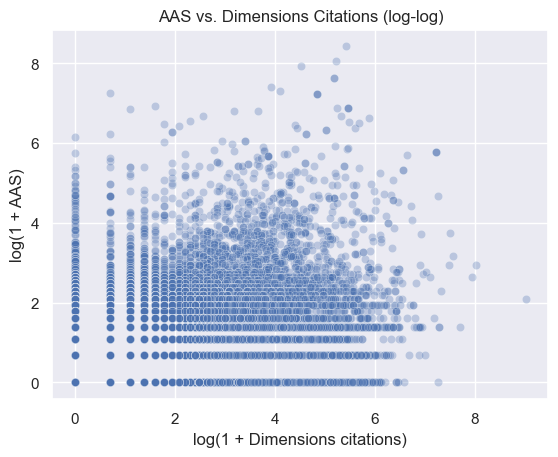

In [ ]:
# Optional: scatterplots (log scale for visibility)
sns.scatterplot(x=np.log1p(df_corr[COL_DIM]), y=np.log1p(df_corr[COL_AAS]), alpha=0.3)
plt.title("AAS vs. Dimensions Citations (log-log)")
plt.xlabel("log(1 + Dimensions citations)")
plt.ylabel("log(1 + AAS)")
plt.show()

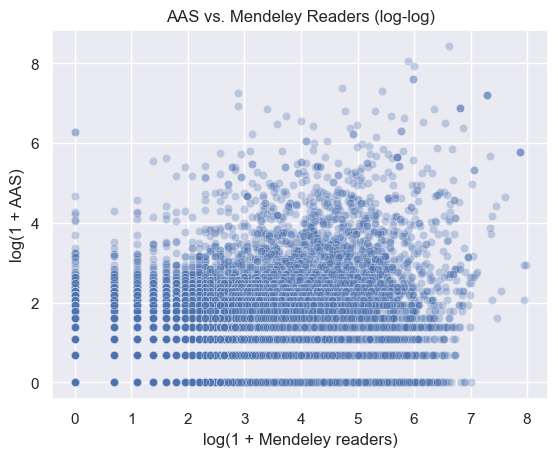

In [34]:
sns.scatterplot(x=np.log1p(df_corr[COL_MEN]), y=np.log1p(df_corr[COL_AAS]), alpha=0.3)
plt.title("AAS vs. Mendeley Readers (log-log)")
plt.xlabel("log(1 + Mendeley readers)")
plt.ylabel("log(1 + AAS)")
plt.show()